<img src="../../thumbnail.png" width=500 alt="Kerchunk Logo"></img>

# Kerchunk Basics

## Overview

This notebook is intended as an introduction to using `Kerchunk`.
In this tutorial we will:
- Scan a single NetCDF file to create a `Kerchunk` virtual dataset
- Learn how to use the output  using `Xarray` and `fsspec`.

While this notebook only examines using `Kerchunk` on a single NetCDF file, `Kerchunk` can be used to create virutal `Zarr` datasets from collections of many input files. In the following notebook, we will demonstrate this. 

## Prerequisites
| Concepts | Importance | Notes |
| --- | --- | --- |
| [Introduction to Xarray](https://foundations.projectpythia.org/core/xarray/xarray-intro.html) | Helpful | Basic features |

- **Time to learn**: 60 minutes
---

## Imports

Here we will import a few `Python` libraries to help with our data processing. 
- `fsspec` will be used to read remote and local filesystems. 
- `kerchunk.hdf` will be used to read a NetCDF file and create a `Kerchunk` index.
- `ujson` for writing the `Kerchunk` output to the `.json` file format.
- `Xarray` for examining out output dataset


In [1]:
import fsspec
import kerchunk.hdf
import ujson
import xarray as xr

### Define kwargs for `fsspec`

In the dictionary definition in the next cell, we are passing options to [`fsspec.open`](https://filesystem-spec.readthedocs.io/en/latest/api.html?highlight=.open#fsspec.open). Any additional kwargs passed in this dictionary through `fsspec.open` will pass as kwargs to the file system, in our case `s3`. The API docs for the `s3fs` filesystem spec can be found [here](https://s3fs.readthedocs.io/en/latest/api.html).

In this example we are passing a few kwargs. In short they are:
- `anon=True`: This is a `s3fs` kwarg that specifies you are not passing any connection credentials and are connecting to a public bucket.
- `default_fill_cache=False`: `s3fs` kwarg that avoids caching in between chunks of files. This may lower memory usage when reading large files.
- `default_cache_type="first"`: `fsspec` kwarg that specifies the caching strategy used buy `fsspec`. In this case, `first` caches the first block of a file only.

Don't worry too much about the details here. 

In [2]:
so = dict(anon=True, default_fill_cache=False, default_cache_type="first")

### Parse a single NetCDF file with kerchunk

Below we will access a NetCDF file stored on the AWS cloud. This dataset is a single time slice of a climate downscaled product for Alaska.

The steps in the cell below are as follows:
1. Define the url that points to the `NetCDF` file we want to process
1. Use `fsspec.open` along with the dictionary of arguments we created about (`so`) to open the URL pointing to the NetCDF file.
1. Use `kerchunk.hdf.SingleHdf5ToZarr` method to read through the `NetCDF` file and extract the byte ranges, compression information and metadata.
1. Use `Kerchunk's` `.translate` method on the output from the `kerchunk.hdf.SingleHdf5ToZarr` to translate content the NetCDF file into the `Zarr` format.
1. Create a `.json` file named `single_file_kerchunk.json` and write the dataset information to disk.


In [3]:
# Input URL to dataset. Note this is a netcdf file stored on s3 (cloud dataset).
url = "s3://wrf-se-ak-ar5/ccsm/rcp85/daily/2060/WRFDS_2060-01-01.nc"

# Uses kerchunk to scan through the netcdf file to create kerchunk mapping and then save output as .json
# Note: In this example, we write the kerchunk output to a .json file.
# You could also keep this information in memory and pass it to fsspec
with fsspec.open(url, **so) as inf:
    h5chunks = kerchunk.hdf.SingleHdf5ToZarr(inf, url, inline_threshold=100)
    h5chunks.translate()
    with open("single_file_kerchunk.json", "wb") as f:
        f.write(ujson.dumps(h5chunks.translate()).encode())

### Load `Kerchunk` Reference File

In the section below we will use `fsspec.filesystem` along with the `Kerchunk` `.json` reference file to open the `NetCDF` file as if it were a `Zarr` dataset.

In [4]:
# use fsspec to create filesystem from .json reference file
fs = fsspec.filesystem(
    "reference",
    fo="./single_file_kerchunk.json",
    remote_protocol="s3",
    remote_options=dict(anon=True),
    skip_instance_cache=True,
)

# load kerchunked dataset with xarray
ds = xr.open_dataset(fs.get_mapper(""), engine="zarr")

/var/folders/mb/7d7yq_4j2qgdfm_j3j4tsyl40000gn/T/ipykernel_8128/1112314070.py:11: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds = xr.open_dataset(fs.get_mapper(""), engine="zarr")


### Plot Dataset

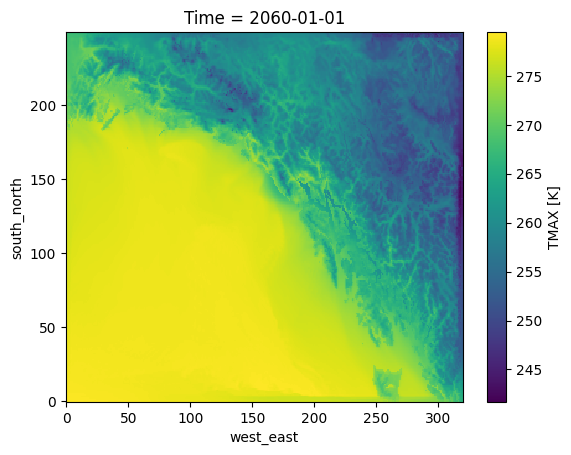

In [5]:
ds.TMAX.plot()